# Reading and Processing Surface Water Data

Upon completing the data processing for GRACE and GLDAS, we will next shift our focus to the acquisition and analysis of surface water data. Surface water data is gathered via reservoir storage monitoring performed at designated monitoring sites for each reservoir. Contrasting with GRACE and GLDAS, surface water data is typically fragmented and region-specific.

This notebook guides you through the process of downloading and analyzing surface water data specific to the Colorado River Basin. The methodologies demonstrated here could be applied to other regions within the United States, given the broad coverage of our data sources. However, for more detailed data, regional websites and databases may prove beneficial. As for regions outside the United States, this notebook should serve as a useful springboard for scraping, processing, and visualizing surface water data.

Surface water data for the Colorado River Basin is distributed across several platforms including:
- [the Bureau of Reclamation](https://www.usbr.gov/uc/water/hydrodata/nav.html)(Reclamation)
- [the United States Geological Survey](https://waterdata.usgs.gov/nwis/sw)(USGS)
- [the US Army Corps of Engineers](https://resreg.spl.usace.army.mil/cgi-bin/slLatestBasin.cgi?gila+elev)
- [the Salt River Project Watershed Connection](https://streamflow.watershedconnection.com/?location=Apache%20Lake%20(Horse%20Mesa%20Dam)&project=undefined)

In this Jupyter Notebook, however, we will restrict our focus to data from the Reclamation and the USGS for the reasons detailed below:

- Research papers that study the groundwater in the Colorado River Basin frequently use data from Lake Powell and Lake Mead to represent the totality of surface water in the basin. This data is readily provided by the Reclamation and USGS.
- The data from the US Army Corps of Engineers only spans the most recent 180 days and that from the Salt River Project extends up to a year. Given our interest in the timeframe from 2002 to 2023 (the most recent year), the data from these two sources is insufficient.

### As we progress through this notebook, you will be guided through the following steps:

<b>Step I:</b> Download Data
1. From the Reclamation
2. From the USGS

<b>Step II:</b> 
Carry out necessary data cleaning and processing to ensure the data is suitable for analysis.

<b>Step III:</b>
Visualize the storage for reservoirs within the basin.

In [40]:
# Loading necessary packages
import csv
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point

import requests
from io import StringIO
from random import randint
from time import sleep
from requests.exceptions import RequestException
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

from fuzzywuzzy import fuzz
from datetime import date
from datetime import timedelta

import matplotlib.pyplot as plt
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import get_provider, Vendors
from bokeh.palettes import Category10, Category20
from bokeh.models import MultiLine
import itertools


## Step I(a): Reading data from the Reclamation

The Reclamation hosted a [hydrologic database access portal](https://www.usbr.gov/uc/water/hydrodata/nav.html) for all relevent data on reservoirs they operated in the area of Colorado River Basin. The data we will be using are:
- a [metadata spreadsheet](https://www.usbr.gov/uc/water/hydrodata/reservoir_data/meta.csv) that include the information about monitoring sites (latitude, longitude, site_id, etc)
- reservoir storage data for each monitoring site measured in acre feet

First, we will gather information (including latitude, longitude, site ID, and name) for each monitoring site. Subsequently, we will use this information to collect data on the surface water storage of reservoirs at each of these monitoring sites.

In [41]:
def read_reclamation_from_url(url):
    '''
    Scrape content from the Bureau of Reclamation website
    '''
    # Define a session for HTTP requests
    session = requests.Session()

    # Define the retry settings: total=5 will attempt the request up to 5 times
    # status_forcelist=[500, 502, 503, 504] will retry if one of these status codes is returned
    retries = Retry(total=5, backoff_factor=0.1, status_forcelist=[500, 502, 503, 504])

    # Mount the retry settings to the session
    session.mount("https://", HTTPAdapter(max_retries=retries))

    try:
        # Send the request and catch any exceptions
        response = session.get(url, timeout=10)
        
        # If the response was successful, parse it as CSV
        if response.status_code == 200:
            data = response.content.decode('utf-8')
            return pd.read_csv(StringIO(data))
        # If the response was unsuccessful, print the status code for response
        else:
            print(f"Failed to download file from {url}, status code: {response.status_code}")
            return None
    # If the request to scrape was unsuccessful, print the error message
    except RequestException as e:
        print(f"Failed to download file: {e}")
        return None

In [42]:
# Load CRB shapefile
basin_shape = gpd.read_file('/home/yhuang21/remoteData/shapefiles/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp')

# Load reservoir data from Bureau of Reclamation
reclamation_reservoir_metadata = read_reclamation_from_url('https://www.usbr.gov/uc/water/hydrodata/reservoir_data/meta.csv') 

In [43]:
# Convert your DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(reclamation_reservoir_metadata['site_metadata.longi'], reclamation_reservoir_metadata['site_metadata.lat'])]
reservoirs_gdf = gpd.GeoDataFrame(reclamation_reservoir_metadata, geometry=geometry)

# Assign a Coordinate Reference System (CRS) to your GeoDataFrame. EPSG:4326 represents WGS 84 - Latitude/Longitude.
reservoirs_gdf.crs = "EPSG:4326"
basin_shape.crs = "EPSG:4326"

# Perform spatial join so that only reservoirs inside the CRB shapefile will be selected
joined_gdf = gpd.sjoin(reservoirs_gdf, basin_shape, predicate='intersects')

# Filter by type_id (17 suggests the data is about reservoir storage) and select relevant columns
reclamation_reservoirs = joined_gdf[joined_gdf['datatype_id'] == 17][['site_metadata.lat', 'site_metadata.longi', 'site_metadata.site_name', 'site_id']]

In [44]:
# Remove duplicate rows
reclamation_reservoirs = reclamation_reservoirs.drop_duplicates().reset_index(drop=True)

# Rename Columns
reclamation_reservoirs = reclamation_reservoirs.rename(columns={'site_metadata.site_name':'name', 'site_metadata.lat':'lat', 'site_metadata.longi':'lon'})
reclamation_reservoirs['name'] = reclamation_reservoirs['name'].str.title()

In [45]:
# Show the first 5 rows of the dataframe
reclamation_reservoirs.head()

lat         lon                            name  site_id
0  40.365100 -105.236000  Flatiron Reservoir Nr Loveland   100081
1  40.320000 -105.210000                     Carter Lake   100065
2  40.600000 -105.170000            Horsetooth Reservoir   100091
3  39.878317 -106.329748        Green Mountain Reservoir   100089
4  39.366647 -106.458926             Homestake Reservoir   100120

Now, we have gathered information including location, name, and site ID for all monitoring sites in the Colorado River Basin, as listed on the Reclamation website. 

Next, we will visualize the distribution of these sites.





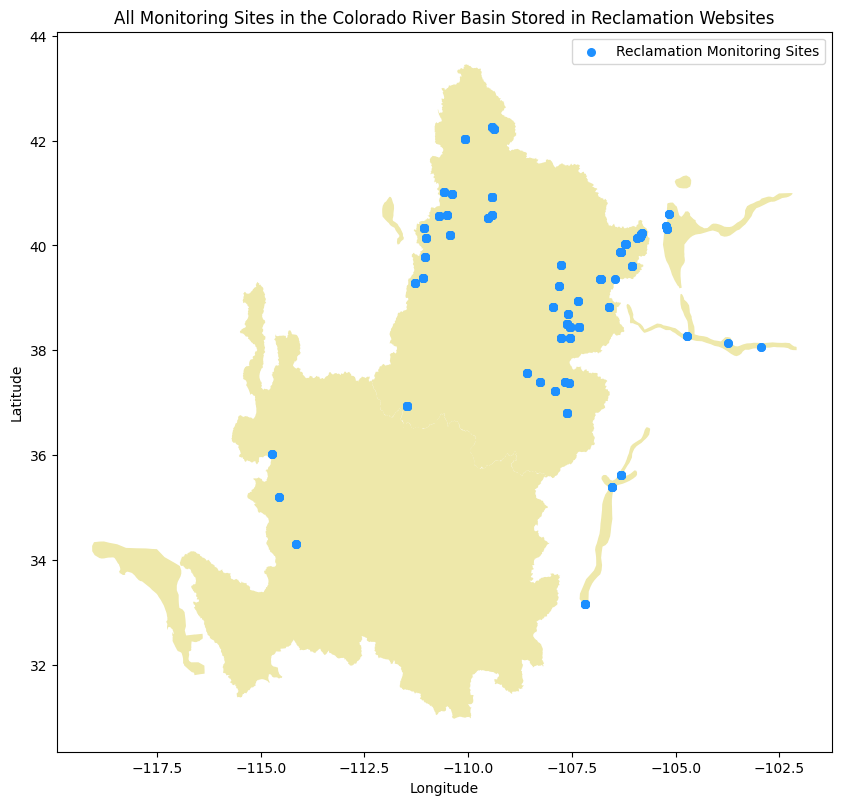

In [46]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the basins
basin_shape.plot(ax=ax, color='palegoldenrod')

# # Plot the reservoirs
joined_gdf.plot(ax=ax, marker='o', color='dodgerblue', markersize=30, label='Reclamation Monitoring Sites')

# # Add title and labels
plt.title('All Monitoring Sites in the Colorado River Basin Stored in Reclamation Websites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.legend()

# Show the plot
plt.show()

In [47]:
# Check if reservoirs have more than one monitoring sites.

if reclamation_reservoirs['name'].nunique() != len(reclamation_reservoirs):
    print('There are multiple monitoring sites at some reservoirs')
else:
    print("All reservoirs have only one monitoring site for each in Reclamation.")

There are multiple monitoring sites at some reservoirs


After we collected the information for each monitoring site stored in the Reclamation website, we can use the site_id associated with them to scrape the surface water storage of each monitoring site.

In [48]:
# URL link to each reservoir's storage data
reclamation_url_head = 'https://www.usbr.gov/uc/water/hydrodata/reservoir_data/'
reclamation_url_tail = '/csv/17.csv'

# Create an empty list to store all the temporary dataframes
reclamation_data_list = []

# Iterate over each row in the reservoir dataframe to scrape the storage data at each monitoring site
for row in reclamation_reservoirs.itertuples(index=False):
    lat, lon, name, id = row
    # Scrape the website
    data = read_reclamation_from_url(reclamation_url_head + str(id) + reclamation_url_tail)

    # Add columns that documents the monitoring well's latitude, longitude, and name
    data['lat'] = lat
    data['lon'] = lon
    data['name'] = name

    #Store each dataframe of the monitoring sites into a list
    reclamation_data_list.append(data)

# Creating a dataframe from the list
reclamation_df = pd.concat(reclamation_data_list).reset_index(drop=True)

## Step I(b): Reading data from the USGS

The process of reading data from the USGS is similar to the process of reading data from the Reclamation. 

We first gathered information for all monitoring sites located in the Colorado River Basin stored in the USGS website following the steps below:
1. We select monitoring sites in USGS by filtering all the sites meeting our criteria using [this website](https://waterdata.usgs.gov/nwis/dv?referred_module=sw&search_criteria=search_site_no&search_criteria=site_tp_cd&submitted_form=introduction)

2. Specifically, we selected monitoring sites fulfilling the following conditions:
 - their site id starting with 09. This denotes the monitoring site is in the Colorado River Basin. A list of site ids with the associated areas can be found in [this website](https://help.waterdata.usgs.gov/faq/sites/do-station-numbers-have-any-particular-meaning)
 - they have reservoir storage, acre-ft as the available parameter
3. Then, we choose the output format option " Site-description information displayed in tab-separated format" and select site identification number, site name, site type, Decimal latitude, Decimal longitude as the fileds to include in the site-description output.

We can then use [the website](https://waterdata.usgs.gov/nwis/dv?referred_module=sw&search_site_no=09&search_site_no_match_type=beginning&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd=LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&index_pmcode_00054=1&group_key=county_cd&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=site_tp_cd&column_name=dec_lat_va&column_name=dec_long_va&range_selection=days&period=365&date_format=YYYY-MM-DD&rdb_compression=file&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection) resulted from these steps to scrape the information.




In [49]:
# Below is the function designed to scrape the necessary information about all the monitoring sites in the Colorado River Basin as maintained by the USGS
def read_usgs_monitoring_sites(url):
    
    response = requests.get(url)
    file_content = response.text

    # Get the line number where data starts
    start_pos = file_content.find("site_no\tstation_nm\tsite_tp_cd\tdec_lat_va\tdec_long_va\tcoord_acy_cd\tdec_coord_datum_cd")

    # Extract data from start line till end
    data_content = file_content[start_pos:]

    # Create a pandas dataframe
    df = pd.read_csv(StringIO(data_content), delimiter='\t')
    df = df.drop(0)

    # Select only the columns of interest
    df = df[['dec_lat_va', 'dec_long_va','station_nm','site_no']]
    df['station_nm'] = df['station_nm'].str.title()
    df = df.rename(columns={'site_no':'site_id', 'station_nm':'name', 'dec_lat_va':'lat', 'dec_long_va':'lon'})

    return df

In [50]:
# Below is the function designed to retrieve surface water storage (reservoir storage) information from the relevant websites
def read_usgs_storage(url):
    
    response = requests.get(url)
    file_content = response.text

    # Get the line number where data starts
    start_pos = file_content.find("agency_cd\tsite_no\tdatetime\t")

    # Extract data from start line till end
    data_content = file_content[start_pos:]

    try:
        # Create a pandas dataframe
        df = pd.read_csv(StringIO(data_content), delimiter='\t')
        df = df.drop(0)
    except pd.errors.EmptyDataError:
        # No data to parse from the file, return None
        return None
    
    # Extract columns of the format 'ddddd_00054_ddddd' (any length of d, d stands for digits)
    # These columns records the surface water storage measured by the monitoring sites
    # The parameter code 00054 denotes reservoir storage 
    pattern = r'^\d+_00054_\d+$'  # regex pattern to match the desired column format
    matched_columns = df.filter(regex=pattern).columns

    # Reservoir storage could be stored as daily mean, exact measurement at 8:00 am, exact measurement at midnight, or instantaneous measurement
    # These are denoted by the chunk of digits following 00054
    
    '''
    ddddd_00054_32400: Reservoir storage at midnight
    ddddd_00054_00011: Instantaneous Reservoir storage
    ddddd_00054_00003: Daily mean of Reservoir storage
    ddddd_00054_30800: Reservoir storage at 8 am
    '''
     
    # Most of the monitoring sites only record one type of observation 
    # For monitoring sites with multiple types of observations, we select only one type of observation to record based on the following order. You can choose any other that makes sense for your analysis
    # In this case, observation type 00003 (Daily mean of Reservoir storage) receive the highest order
    column_order = ['00003', '32400', '30800', '00011']

    # Select the first column that exists in the DataFrame according to your order
    for end_digits in column_order:
        column_name = next((col for col in matched_columns if col.endswith(end_digits)), None)
        if column_name:
            df = df[['datetime', column_name]]
            df = df.rename(columns={column_name: 'storage'})
            df.replace('NaN', np.nan, inplace=True)
            df['storage'] = pd.to_numeric(df['storage'], errors='coerce')
            break
    
    return df

In [51]:
# Retrieve monitoring sites info from url
usgs_reservoirs = read_usgs_monitoring_sites('https://waterdata.usgs.gov/nwis/dv?referred_module=sw&search_site_no=09&search_site_no_match_type=beginning&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd=LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&index_pmcode_00054=1&group_key=county_cd&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=site_tp_cd&column_name=dec_lat_va&column_name=dec_long_va&range_selection=days&period=365&date_format=YYYY-MM-DD&rdb_compression=file&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection')

# Covert column types
usgs_reservoirs['lat'] = usgs_reservoirs['lat'].astype(float)
usgs_reservoirs['lon'] = usgs_reservoirs['lon'].astype(float)

# Define function to clean monitoring sites name
def clean_station_name(name):
    for separator in [" Near ", " At "]:
        name = name.split(separator)[0]
    return name

# Apply function to clean monitoring sites names 
# We want to clean the names because some of the USGS monitoring sites may overlap with the Reclamation monitoring sites
# We use the monitoring sites names as a comparison criteria to determine if the sites are the same
# Before cleaning, most of the USGS reservoir names look like "RIFLE GAP RESERVOIR NEAR RIFLE, CO"
# We are formating them as "RIFLE GAP RESERVOIR"
usgs_reservoirs['name'] = usgs_reservoirs['name'].apply(clean_station_name)

In [52]:
# Preview of the dataframe storing monitoring sites information from USGS
usgs_reservoirs.head()

lat         lon                                    name   site_id
1  40.112763 -106.415032  Wolford Mtn Reservoir Nr Kremmling, Co  09041395
2  39.626925 -107.757565                     Rifle Gap Reservoir  09091900
3  39.224980 -107.811730                          Vega Reservoir  09096100
4  38.817717 -106.605239                   Taylor Park Reservoir  09108500
5  38.232769 -107.541726                   Silver Jack Reservoir  09125800

Now, we have gathered information including location, name, and site ID for all monitoring sites in the Colorado River Basin, as listed on the USGS website. 

Next, we will visualize the distribution of these sites.

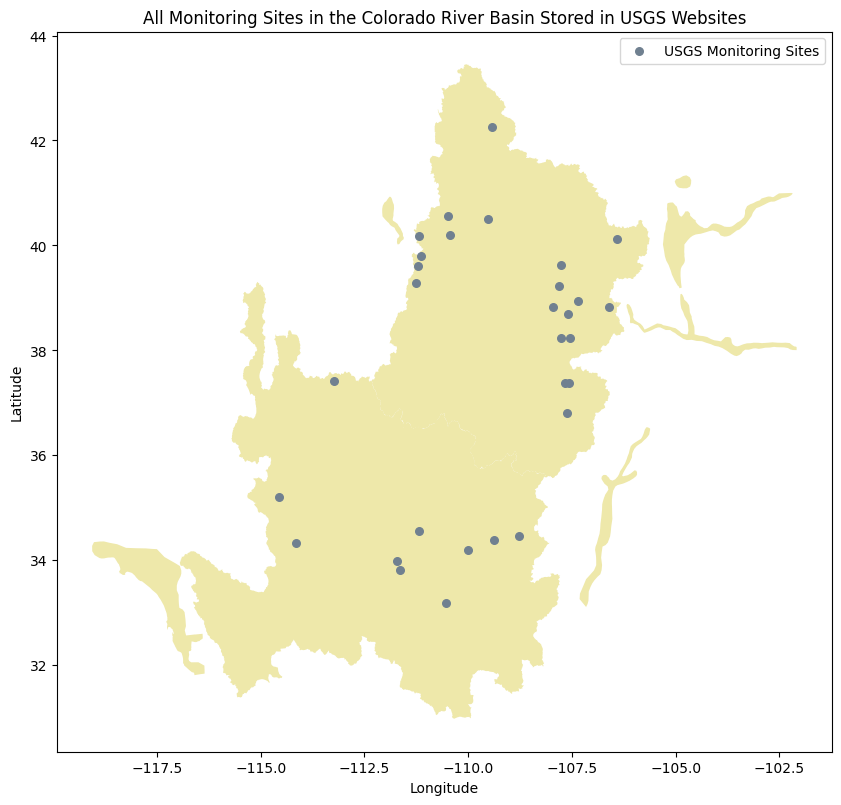

In [53]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the basins
basin_shape.plot(ax=ax, color='palegoldenrod')

# Convert your DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(usgs_reservoirs['lon'], usgs_reservoirs['lat'])]
usgs_reservoirs_gdf = gpd.GeoDataFrame(usgs_reservoirs, geometry=geometry)
usgs_reservoirs_gdf.crs = "EPSG:4326"

# # Plot the reservoirs
usgs_reservoirs_gdf.plot(ax=ax, marker='o', color='slategrey', markersize=30, label='USGS Monitoring Sites')

# # Add title and labels
plt.title('All Monitoring Sites in the Colorado River Basin Stored in USGS Websites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.legend()

# Show the plot
plt.show()

In [54]:
# Check if reservoirs have more than one monitoring sites.
# We will keep only one monitoring site for each reservoir if the data from the monitoring sites are similar
if usgs_reservoirs['name'].nunique() != len(usgs_reservoirs):
    print('There are multiple monitoring sites at some reservoirs')
else:
    print("All reservoirs have only one monitoring site for each in USGS.")

All reservoirs have only one monitoring site for each in USGS.


In [55]:
# URL link to each reservoir's storage data
usgs_url_head = 'https://waterdata.usgs.gov/nwis/dv?cb_00054=on&format=rdb&site_no='
yesterday = date.today() - timedelta(days = 1)
usgs_url_tail = '&legacy=&referred_module=sw&period=&begin_date=2002-01-01&end_date=' + str(yesterday)

# Create an empty list to store all the temporary dataframes
usgs_data_list = []

# Iterate over each row in the reservoir dataframe to scrape the storage data at each monitoring site
for row in usgs_reservoirs.itertuples(index=False):
    lat, lon, name, id = row
    data = read_usgs_storage(usgs_url_head + str(id) + usgs_url_tail)
    if data is not None:
       
        data['lat'] = lat
        data['lon'] = lon
        data['name'] = name

        #Store each dataframe of the monitoring sites into a list
        usgs_data_list.append(data)

# Creating a dataframe from the list
usgs_df = pd.concat(usgs_data_list).reset_index(drop=True)

## Step II: Cleaning and Processing Both the Reclamation and USGS Datasets

In our dataset, we are dealing with repetitive monitoring sites stored in both the Reclamation dataset and the USGS dataset. 

For example, in the USGS dataset, one reservoir is named `fruit growers reservoir`, yet it is named `fruit growers reservoir` in the Reclamation dataset.
Even though they are the same thing, directly comparing their names would suggest they are different.

To resolve this issue, we consider monitoring sites in USGS and the Reclamation to be the same if they satisfy <b>both</b> of the following conditions:
1. The distance between their latitudes and longitudes are smaller than 0.05 degree
2. Their names receive a similarity score higher than 90 or if the Reclamation name is a substring of the name in USGS
 
For pairs of monitoring sites in USGS and the Reclamation that satisfy the above conditions, we change the name of the USGS monitoring site to be same as the Reclamation monitoring site.

The idea is to calculate average of the repetitive monitoring sites and use them in the final visualization.
This step will allow us to do so.

In [56]:

# Iterate over each row in usgs_reservoirs
for i, row in usgs_reservoirs.iterrows():
    lat, lon, usgs_name = row['lat'], row['lon'], row['name'].lower()
    
    # Find rows in Reclamation reservoirs where the distance between its latitude and USGS reservoir's lat is  within the threshold (0.05) AND the distance between the longitudes are also within the threshold
    mask = ((reclamation_reservoirs['lat'] - lat).abs() < 0.05) & ((reclamation_reservoirs['lon'] - lon).abs() < 0.05)
    # For reclamation reservoirs that are too close to the USGS reservoir we are iterating, compare the names of the reclamation reservoir to the USGS reservoir
    for j, row_res in reclamation_reservoirs[mask].iterrows():
        print("---------")
        print('Name from USGS:', usgs_name)
        reclamation_name = row_res['name'].lower()
        print('Name from Reclamation:', reclamation_name)
        score = fuzz.ratio(usgs_name, reclamation_name)
        print('Similarity score', score)

        # We drop the USGS monitoring well if the reclamation reservoir name is too similar to the USGS reservoir name (similarity score > 90)
        if score > 90 or reclamation_name in usgs_name:
            usgs_reservoirs.at[i, 'name'] = row_res['name']
            break


---------
Name from USGS: rifle gap reservoir
Name from Reclamation: rifle gap reservoir
Similarity score 100
---------
Name from USGS: vega reservoir
Name from Reclamation: vega reservoir
Similarity score 100
---------
Name from USGS: taylor park reservoir
Name from Reclamation: taylor park reservoir
Similarity score 100
---------
Name from USGS: silver jack reservoir
Name from Reclamation: silver jack reservoir
Similarity score 100
---------
Name from USGS: crawford reservoir
Name from Reclamation: crawford reservoir
Similarity score 100
---------
Name from USGS: paonia reservoir
Name from Reclamation: paonia reservoir
Similarity score 100
---------
Name from USGS: fruit growers reservoir
Name from Reclamation: fruitgrowers reservoir
Similarity score 98
---------
Name from USGS: ridgway reservoir
Name from Reclamation: ridgway reservoir
Similarity score 100
---------
Name from USGS: big sandy reservoir
Name from Reclamation: big sandy reservoir
Similarity score 100
---------
Name fro

Now in the datasets, we have a few reservoirs that have multiple monitoring sites. These monitoring sites were either found in both the USGS and the Reclamation datasets or appeared more than once in one datasource.

To deal with them, we will take the average coordinates of the repetitive monitoring sites, so that every reservoir will only have one monitoring site.

Later (but not in this code chunk), we will also take the average observation of the storage in the monitoring sites.

In [59]:
# Adding the source column to distinguish monitoring sites from USGS and Reclamation in the all_reservoirs_info dataframe
usgs_reservoirs['source'] = 'USGS'
reclamation_reservoirs['source'] = 'Bureau of Reclamation'
all_reservoirs_info = pd.concat([usgs_reservoirs, reclamation_reservoirs]).reset_index(drop=True)

# Create a dataframe that stores monitoring sites that appear more than once
repetitive_reservoirs = all_reservoirs_info[all_reservoirs_info.duplicated('name', keep=False)]

# Create a list of monitoring sites that appear only once (unique reservoirs)
unique_reservoirs = all_reservoirs_info.drop(repetitive_reservoirs.index)

# Create dataframes that store unique reservoirs from the USGS source and Reclamation source respectively
unique_usgs_reservoirs = unique_reservoirs[unique_reservoirs['source'] == 'USGS']
unique_reclamation_reservoirs = unique_reservoirs[unique_reservoirs['source'] == 'Bureau of Reclamation']

# Compute the averaged lat and lon for repetitive monitoring sites
repetitive_reservoirs = repetitive_reservoirs.groupby('name').agg({'lat':'mean', 'lon':'mean'}).reset_index()
repetitive_reservoirs['source'] = 'Repetitive'

# # Load shapefile using geopandas
basin_shape = gpd.read_file('/home/yhuang21/remoteData/shapefiles/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp')

# Extract the x and y coordinates of the basins
basin_shape['x'] = basin_shape.geometry.apply(lambda geom: geom.exterior.xy[0])
basin_shape['y'] = basin_shape.geometry.apply(lambda geom: geom.exterior.xy[1])

# Get the bounds of the shapefile
bounds = basin_shape.total_bounds
x_range = (bounds[0], bounds[2])  # minx, maxx
y_range = (bounds[1], bounds[3])  # miny, maxy

# Drop the geometry column and convert to a DataFrame for use with Bokeh
basin_shape_df = basin_shape.drop(columns=['geometry']).copy()

# Create a ColumnDataSource with your basin data
basin_source = ColumnDataSource(basin_shape_df)

# Create a list of your DataFrames and a corresponding list of their sources for the legend
dataframes = [unique_usgs_reservoirs, unique_reclamation_reservoirs, repetitive_reservoirs]
sources = ['USGS', 'Bureau of Reclamation', 'Repetitive']

# Render plot inline in Jupyter notebook
output_notebook()

# Create an empty figure with the new x_range and y_range
p = figure(
    title='All Monitoring Sites in the Colorado River Basin recorded in USGS and Reclamation',
    x_axis_label='Longitude',
    y_axis_label='Latitude',
    x_range=x_range,
    y_range=y_range,
    tools='pan,wheel_zoom,xbox_select,reset', 
    width=1000,
    height=800
)

# Add a map
p.add_tile(get_provider(Vendors.CARTODBPOSITRON))  

# Add the basin outlines to your plot
p.multi_line('x', 'y', source=basin_source, color='black', alpha=0.5, line_width=2)

# Add a circle glyph for each source of reservoirs
for i, df in enumerate(dataframes):
    source = ColumnDataSource(df)
    p.circle('lon', 'lat', source=source, color=Category10[10][i], legend_label=sources[i])

# Add hover tool
hover = HoverTool()
hover.tooltips = [
    ('Name', '@name'), 
    ('Latitude', '@lat'),
    ('Longitude', '@lon')
]
p.add_tools(hover)

# Show the plot
show(p)  


Loading BokehJS ...

In [60]:
all_reservoirs_info

lat         lon                                    name   site_id  \
0   40.112763 -106.415032  Wolford Mtn Reservoir Nr Kremmling, Co  09041395   
1   39.626925 -107.757565                     Rifle Gap Reservoir  09091900   
2   39.224980 -107.811730                          Vega Reservoir  09096100   
3   38.817717 -106.605239                   Taylor Park Reservoir  09108500   
4   38.232769 -107.541726                   Silver Jack Reservoir  09125800   
..        ...         ...                                     ...       ...   
87  35.628230 -106.317160                            Cochiti Lake      2696   
88  35.394720 -106.544720                  Jemez Canyon Reservoir      2744   
89  36.016300 -114.737400                               Lake Mead       921   
90  35.197900 -114.569400                             Lake Mohave       922   
91  34.296400 -114.138500                             Lake Havasu       923   

                   source  
0                    USGS  
1                    USGS  
2                    USGS  
3                    USGS  
4                    USGS  
..                    ...  
87  Bureau of Reclamation  
88  Bureau of Reclamation  
89  Bureau of Reclamation  
90  Bureau of Reclamation  
91  Bureau of Reclamation  

[92 rows x 5 columns]

In [63]:
# suppose your list of dataframes is df_list
storage_df = pd.concat([reclamation_df, usgs_df], ignore_index=True)

# Convert the datetime column to datetime object
storage_df['datetime'] = pd.to_datetime(storage_df['datetime'])

# Create a period column for Year-Month
storage_df['YearMonth'] = storage_df['datetime'].dt.to_period('M')

# Group by YearMonth, lat, lon, name, then calculate the mean of storage
storage_df = storage_df.groupby(['YearMonth', 'lat', 'lon', 'name'], as_index=False).agg({'storage':'mean'})

# If you want to rename 'YearMonth' back to 'datetime':
storage_df.rename(columns={'YearMonth': 'datetime'}, inplace=True)

# Only selecting data from 2002 and onwards
storage_df = storage_df[storage_df['datetime'] >= '2002-01-01']

# # For reservoirs with multiple monitoring stations, compute the average of the reservoir storage monitored by these stations for each month
storage_df =storage_df.groupby(['datetime', 'name']).agg({
    'lat': 'mean',
    'lon': 'mean',
    'storage': 'mean'
}).reset_index()

In [64]:
storage_df.head()

datetime                 name        lat         lon        storage
0  2002-01   Bartlett Reservoir  33.818097 -111.631805   66042.903226
1  2002-01  Big Sandy Reservoir  42.249524 -109.428663    3293.990968
2  2002-01  Blue Mesa Reservoir  38.453050 -107.336770  538478.621613
3  2002-01          Carter Lake  40.320000 -105.210000   73129.161290
4  2002-01         Cochiti Lake  35.628230 -106.317160   49935.483871

In [65]:
# Define the bin size
bin_size = 0.25

# Bin the latitude and longitude data and calculate the midpoint
storage_df['lat'] = (np.floor(storage_df['lat'] / bin_size) * bin_size) + bin_size / 2
storage_df['lon'] = (np.floor(storage_df['lon'] / bin_size) * bin_size) + bin_size / 2

# convert unit from acre-feet to cubic kilometer
storage_df['storage'] = storage_df['storage'] * 0.000001233

In [66]:
output_notebook()  # Render plot inline in Jupyter notebook

# Determine the two reservoirs with the highest storage
highest_storages = storage_df.groupby('name')['storage'].max().nlargest(2)
highest_storages_names = highest_storages.index.tolist()

# Create a color dictionary for the two reservoirs
color_dict = {highest_storages_names[0]: 'darkblue', highest_storages_names[1]: 'lightblue'}

# Create a color iterator for the other reservoirs
colors = itertools.cycle(Category20[20])

p = figure(
    title='Reservoir Storage Over Time',
    x_axis_label='Date',
    y_axis_label='Storage (cubic kilometer)',
    x_axis_type='datetime',
    width=800, 
    height=600
)

# Increase the font size for the title and axes labels
p.title.text_font_size = '16pt'
p.xaxis.axis_label_text_font_size = '12pt'
p.yaxis.axis_label_text_font_size = '12pt'

# Iterate over the reservoir groups and plot each one
for name, group in storage_df.groupby('name'):
    source = ColumnDataSource(group)
    if name in highest_storages_names:
        color = color_dict[name]
    else:
        color = next(colors)
    p.line(x='datetime', y='storage', source=source, line_width=2, color=color)

# Add hover tool
hover = HoverTool()
hover.tooltips = [
    ('Name', '@name'),
    ('Date', '@datetime{%F}'),
    ('Storage', '@storage')
]
hover.formatters={'@datetime': 'datetime'}
p.add_tools(hover)

show(p)  # Show the plot

Loading BokehJS ...

In [67]:
storage_df.to_csv('reservoir_storage.csv', index=False)